# Hexa Stat Core Enhancement Analysis

Just an attempt to see how the hexa core stat can somehow be optimized. We start with a bit of sanity analysis, after which we can test a few of the methods derived by KMS players to evaluate the total costs. Finally, if possible, we attempt to derive our own policy function to try and optimize the overall fragment cost usage.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

## Sanity Checks

We should first try and make sure that our resultant values make sense.

In [19]:
# load file and observe attributes
with open("./res_output_0target.pkl", 'rb') as inFile:
    hexaRes = pickle.load(inFile)

print("Current test output contains {} entries.".format(len(hexaRes)))
for key in hexaRes[0].keys():
    print("Found unique key: {}".format(key))

Current test output contains 5000000 entries.
Found unique key: totalFragCost
Found unique key: totalEnhances
Found unique key: primaryLevel
Found unique key: secondaryLevel
Found unique key: thirdLevel
Found unique key: numResets


In [20]:
# Load this into a pandas dataframe to make plotting simpler
hexDf = pd.DataFrame.from_dict(hexaRes)
hexDf.head(10)

,totalFragCost,totalEnhances,primaryLevel,secondaryLevel,thirdLevel,numResets
0,230,20,3,10,7,0
1,360,20,5,8,7,0
2,300,20,5,6,9,0
3,310,20,5,8,7,0
4,330,20,6,10,4,0
5,350,20,7,6,7,0
6,260,20,5,8,7,0
7,340,20,4,10,6,0
8,270,20,6,6,8,0
9,370,20,8,7,5,0


Seems simple enough. The first things we want to consider is the general spread of primary levels. Considering that there are 19 levels total and the rate of successfully enhancing the primary level continues to decrease, it should be fairly difficult for the average player to achieve a primary level of 9/10. Of course, we would also be interested in the total fragment cost from enhancement as well. Keep in mind that enhancement costs are completely dependent on how early the primary stat levels. If primary level enhancements are consolidated towards the end, then there is a chance that the cost for two cores that finish with exactly the same primary/secondary/secondary levels to have different cost values.

In [21]:
# function to plot a meanline for a given distribution
def plotMeanLine(dataset: pd.Series, axis, meanMult: float = 1.2) -> None:
    """
    Plots the meanline of a given dataframe series (essentially one column but indexed).

    Args:
        dataset: The series object for which to find and plot the mean fo
        axis: The axis corresponding to the plot for which the mean should be plotted
    """
    curMean = dataset.mean()
    curStd = dataset.std()
    axis.axvline(curMean, color = 'k', linestyle = 'dashed', linewidth = 1)
    axis.text(curMean*meanMult, axis.get_ylim()[1]*0.75, 'Mean: {:.2f}\nSD: {:.2f}'.format(curMean, curStd))

For relevant element totalFragCost:
	Max: 730
	Min: 200
For relevant element primaryLevel:
	Max: 10
	Min: 0
For relevant element secondaryLevel:
	Max: 10
	Min: 0
For relevant element totalEnhances:
	Max: 20
	Min: 20


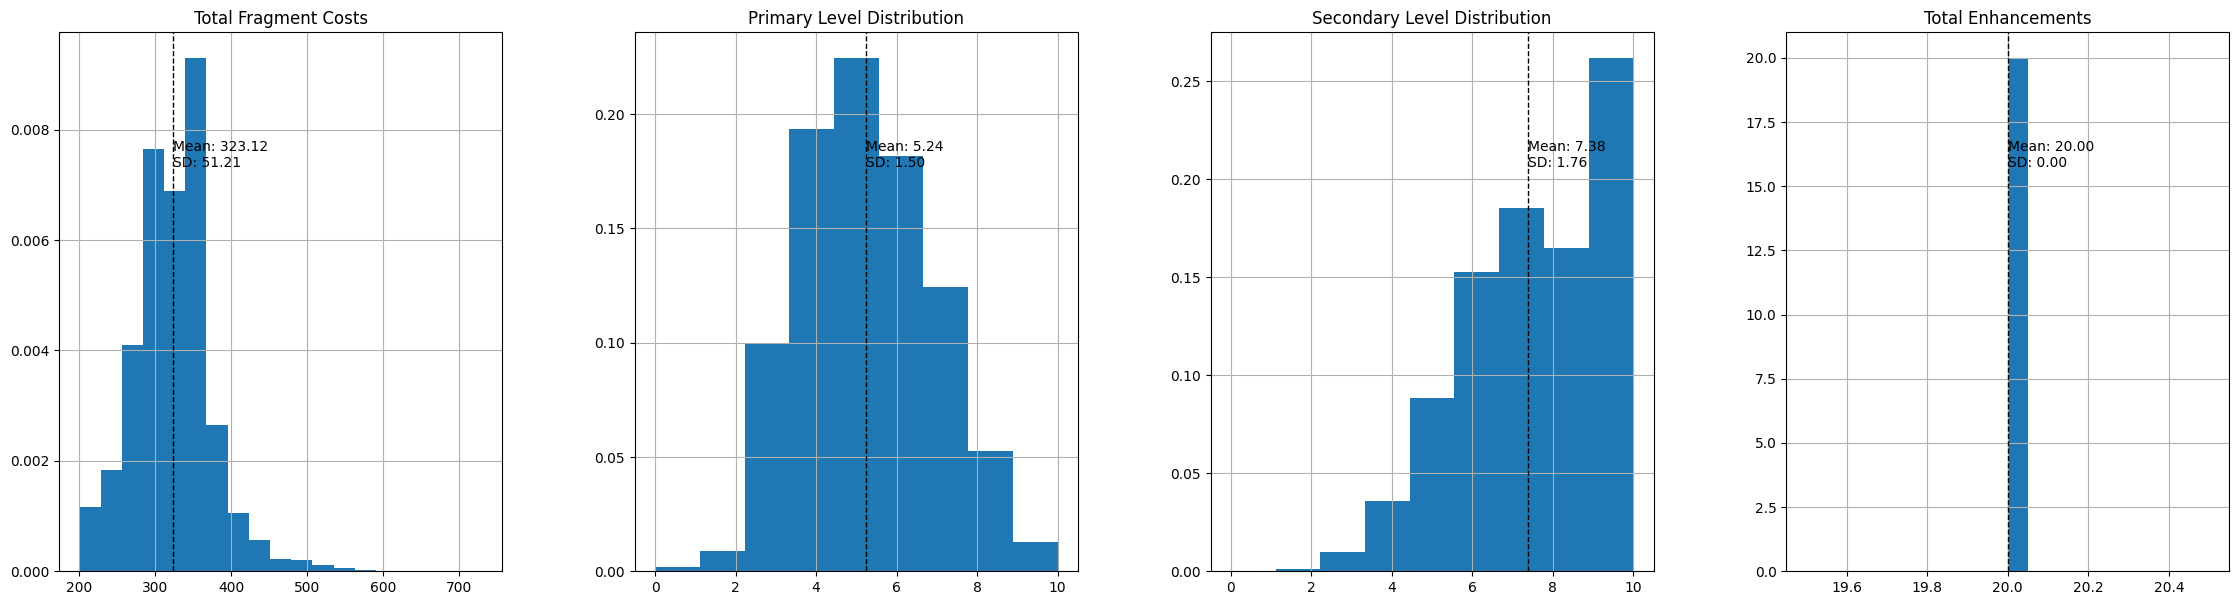

In [22]:
# plot hists and meanlines
fig, ax = plt.subplots(1, 4, figsize = (28, 7))
binCnts = [19, 9, 9, 20]
plotNames = ["Total Fragment Costs", "Primary Level Distribution", "Secondary Level Distribution", "Total Enhancements"] # secondary / tertiary distribution is equivalent

for elemInd, relElem in enumerate(['totalFragCost', 'primaryLevel', 'secondaryLevel', 'totalEnhances']):
    hexDf.hist([relElem], bins = binCnts[elemInd], ax = ax[elemInd], density = True)
    ax[elemInd].set_title(plotNames[elemInd])
    plotMeanLine(hexDf[relElem], ax[elemInd], meanMult = 1.0)

    print("For relevant element {}:\n\tMax: {}\n\tMin: {}".format(relElem, hexDf[relElem].max(), hexDf[relElem].min()))

With the above, we can go ahead and derive the estimated probability of reaching certain primary levels for each of the 5 million trials as well:

In [23]:
odds = list()
for primLevel in range(11):
    odds.append((hexDf[hexDf['primaryLevel'] == primLevel].count()/hexDf.count())['primaryLevel'])
    print("Expected odds of hitting primary level {: >2} from using no policy: E[X={: >2}] = {:0.4f}".format(primLevel, primLevel, odds[-1]))
    print("\tExpected cost: {:.0f}".format((hexDf[hexDf['primaryLevel'] == primLevel])['totalFragCost'].mean()))

Expected odds of hitting primary level  0 from using no policy: E[X= 0] = 0.0002
	Expected cost: 200
Expected odds of hitting primary level  1 from using no policy: E[X= 1] = 0.0020
	Expected cost: 200
Expected odds of hitting primary level  2 from using no policy: E[X= 2] = 0.0100
	Expected cost: 200
Expected odds of hitting primary level  3 from using no policy: E[X= 3] = 0.1103
	Expected cost: 278
Expected odds of hitting primary level  4 from using no policy: E[X= 4] = 0.2150
	Expected cost: 303
Expected odds of hitting primary level  5 from using no policy: E[X= 5] = 0.2496
	Expected cost: 317
Expected odds of hitting primary level  6 from using no policy: E[X= 6] = 0.2021
	Expected cost: 327
Expected odds of hitting primary level  7 from using no policy: E[X= 7] = 0.1384
	Expected cost: 357
Expected odds of hitting primary level  8 from using no policy: E[X= 8] = 0.0582
	Expected cost: 405
Expected odds of hitting primary level  9 from using no policy: E[X= 9] = 0.0131
	Expected 

But this might be unrealistic because we never really aim for just the given probability. So we adjust our expecations to form a range. We would like to reach "at least" a given level; in other words, we calculate $E[X \ge x_D]$.

In [30]:
for primLevel in range(11):
    print("Expected odds of hitting at least primary level {: >2} from using no policy: E[X>={: 2}] = {:0.4f}".format(primLevel, primLevel, sum(odds[primLevel-2:])))

print("\n\tOverall expected final level: E[X] = {:0.4f}".format(sum([oddVal * polLevel for oddVal, polLevel in zip(odds, range(11))])))

Expected odds of hitting at least primary level  0 from using no policy: E[X>= 0] = 0.0142
Expected odds of hitting at least primary level  1 from using no policy: E[X>= 1] = 0.0011
Expected odds of hitting at least primary level  2 from using no policy: E[X>= 2] = 1.0000
Expected odds of hitting at least primary level  3 from using no policy: E[X>= 3] = 0.9998
Expected odds of hitting at least primary level  4 from using no policy: E[X>= 4] = 0.9979
Expected odds of hitting at least primary level  5 from using no policy: E[X>= 5] = 0.9879
Expected odds of hitting at least primary level  6 from using no policy: E[X>= 6] = 0.8776
Expected odds of hitting at least primary level  7 from using no policy: E[X>= 7] = 0.6626
Expected odds of hitting at least primary level  8 from using no policy: E[X>= 8] = 0.4130
Expected odds of hitting at least primary level  9 from using no policy: E[X>= 9] = 0.2109
Expected odds of hitting at least primary level 10 from using no policy: E[X>= 10] = 0.072

This seems to be in line with what was extrapolated using a purely probabalistic argument for KMS players, so seems like the findings are proper. There also doesn't seem to be any deviations from the expected fragment costs aside from the fact that the meso costs have been ignored and the initial costs have also been ignored (they are insignificant in the long run and no longer an issue following the unlocking of the core).

### Percentile View

One thing that is fairly interesting is the calculation of percentiles for the above data. In a typical commulative mass function, we look at the probability of our state space being smaller than some given input state value $x$. Naturally, for the max value and higher in the state space, this corresponds to a cmf value of $1$. Likewise, the value for any state space values less than the minimum would correspond to a cmf value of $0$.

Our percentile view then, can be seen as the inverse of this mapping. In that sense, we have a mapping in $\left[0,1\right]$ that now describes the relationship $x = P\left(X=y\right)$.

(0.0, 11.0)

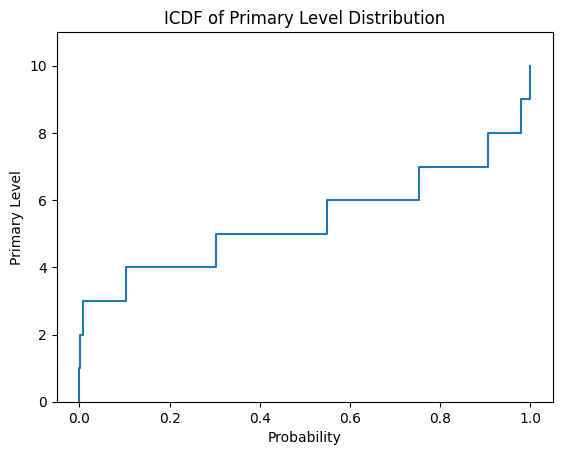

In [25]:
# First we can calculate the cdf over our primary level distribution
cdfSeries = hexDf.groupby(['primaryLevel']).sum()['totalFragCost']
cdfSeries = (cdfSeries / cdfSeries.sum()).cumsum()

# We can then invert it to find our icdf
icdf = pd.Series({value:key for key, value in cdfSeries.to_dict().items()})

# And we can go ahead and plot the icdf
ax = icdf.plot(drawstyle = "steps")
ax.set_title("ICDF of Primary Level Distribution")
ax.set_xlabel("Probability")
ax.set_ylabel("Primary Level")
ax.set_ylim([0, 11])

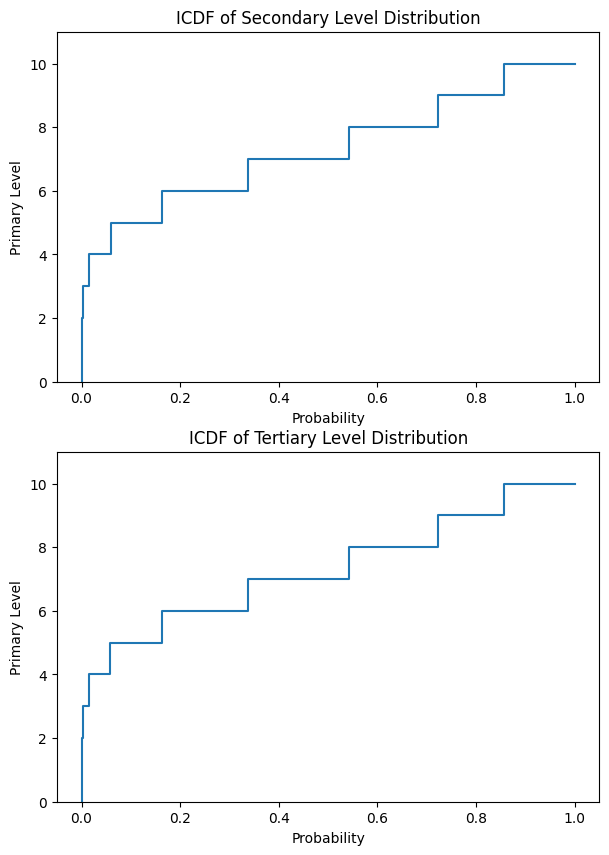

In [38]:
# And then we can go ahead and do the same for the secondary level and tertiary levels
cdfSSeries = hexDf.groupby(['secondaryLevel']).sum()['totalFragCost']
cdfSSeries = (cdfSSeries / cdfSSeries.sum()).cumsum()
hexDf['tertiaryLevel'] = 20 - (hexDf['primaryLevel'] + hexDf['secondaryLevel'])
cdfTSeries = hexDf.groupby(['tertiaryLevel']).sum()['totalFragCost']
cdfTSeries = (cdfTSeries / cdfTSeries.sum()).cumsum()

# We can then invert it to find our icdf
sicdf = pd.Series({value:key for key, value in cdfSSeries.to_dict().items()})
ticdf = pd.Series({value:key for key, value in cdfTSeries.to_dict().items()})

# And we can go ahead and plot the icdf
fig, ax = plt.subplots(2, 1, squeeze = True, figsize = (7, 10))
ax1, ax2 = ax
sicdf.plot(drawstyle = "steps", ax = ax1)
ticdf.plot(drawstyle = "steps", ax = ax2)
for curInd, curAx in enumerate(ax):
    curAx.set_title("ICDF of {} Level Distribution".format("Secondary" if curInd == 0 else "Tertiary"))
    curAx.set_xlabel("Probability")
    curAx.set_ylabel("Primary Level")
    curAx.set_ylim([0, 11])

This may look weird at first, but remember that our commulative mass function describes the following probability, $P(X\le x)$. In other words, it tells us what is the probability of our random variable being *at most* a certain value, $x$. The inverse, then, must then map these probabilities to a given input state variable that corresponds to the point $x_a$ such that $p = P(X\le x_a)$. So, by looking at the above we actually describe our percentiles, or the percentage of the population that will fall under some given coverage of the input state variable. Interestingly enough, by calculating the quantity $\left(1-ICDF(p)\right)$, we can then also infer the luckier subset of the population (while keeping in mind that the inverse of $X\le x_a$ is $X\gt x_a$ so this will generate a slight shift in the distribution). This is not extremely useful with a scenario with such a small input state space (as much of this can easily be calculated in your head), but it might prove useful to calculate for larger distributions with a much larger input state space.

One large thing to notice is that while the primary level distribution seems somewhat heavily weighted towards the center (which is expected considering the decreasing odds of enhancement), the secondary and tertiary levels are heavily weighted towards the higher end values! In fact, just looking at this graph we can easily see that the median level for the secondary and tertiary stats will be $7$, while the median level for the primary stat will be $5$.

## Desired Levels and Inefficiencies

Note that in the above simulation we only asked the simulator to return any level that was possible (as our target was 1, the minimum level). However, that's not quite practical in practice as the point of a game would be to try and push the limits of enhancement as much as possible. In general, it seems as though the desired levels have been set to hover around levels 6 or 7 for average players while significantly more funded players might venture out to the point of trying to hit levels 8 or 9 (10 is too unrealistic for anyone at the current rates). The following shows us the same information from above but for a desired outcome level of 8.

For relevant element totalFragCost:
	Max: 59640
	Min: 260
For relevant element totalEnhances:
	Max: 3740
	Min: 20
For relevant element primaryLevel:
	Max: 10
	Min: 8
For relevant element secondaryLevel:
	Max: 10
	Min: 0


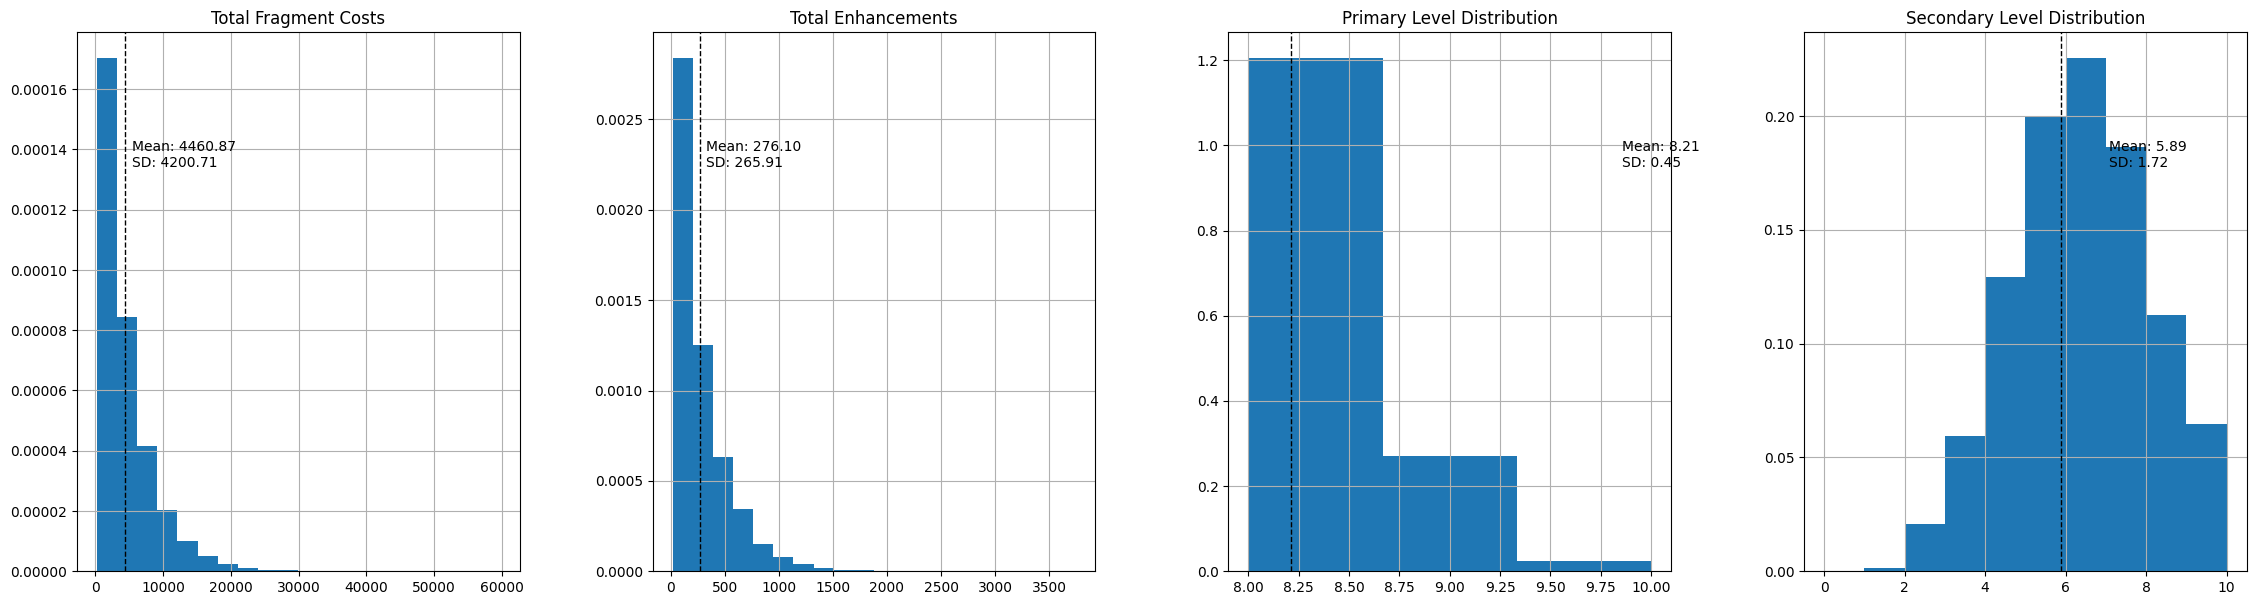

In [13]:
with open("./res_output_8target.pkl", 'rb') as inFile:
    hexaRes = pickle.load(inFile)
hexDf = pd.DataFrame.from_dict(hexaRes)
del hexaRes

# plot hists and meanlines
binCnts = [20, 20, 3, 10] # our primary will only be 8/9/10
fig, ax = plt.subplots(1, 4, figsize = (28, 7))
plotNames = ["Total Fragment Costs", "Total Enhancements", "Primary Level Distribution", "Secondary Level Distribution"]

for elemInd, relElem in enumerate(['totalFragCost', 'totalEnhances', 'primaryLevel', 'secondaryLevel']):
    hexDf.hist([relElem], bins = binCnts[elemInd], ax = ax[elemInd], density = True)
    ax[elemInd].set_title(plotNames[elemInd])
    plotMeanLine(hexDf[relElem], ax[elemInd])

    print("For relevant element {}:\n\tMax: {}\n\tMin: {}".format(relElem, hexDf[relElem].max(), hexDf[relElem].min()))

From above, we can see that on average to get a primary stat level of 8 or above, we would have to spend approximately 3000 erda fragments on average before we hit this lower limit. This is a true estimate of the overall trial compared to above, which only estimated the cost of a single trial that happened to end up at level 8. Naturally, the cost would scale up to reflect that a primary stat level of 8 or above is quite rare (with acquire percentage 10.24% thus increasing our costs approximately 10-fold).

## Policy Functions and Output Distributions

One of the biggest things about this form of enhancement is that the costs can ramp up severely if the node is constantly taken to level 20 prior to resetting. There is a lower limit on resetting the node placed at level 10, but perhaps it would be in our best interest to reset the node if we can't reach a specific level by that point. One thing to consider would be to formulate a policy function, $\pi:S\to A$, which is a mapping from the state space of the enhancement process to an action (in this case, resetting vs not resetting such that $|A|=2$). Since secondary and tertiary stat levels are not significant to separate, we can summarize our state space, $S$, as follows:

$$b=\{1,2,...,10\}\times\{1,2,...,10\}$$
$$S = \{\left(x,y\right)|\left(x,y\right)\in b,\ x \ge y\}$$

In this formulation, our $x$ is essentially the level of the node while $y$ is the level of our primary stat. It may seem that with this state space that we are making the assumption that our secondary levels might not matter, but the truth is that such information is already encoded into our state space in $x$. Any combinations outside of this state space doesn't matter as it is not reachable within the context of the simulation. Normally, our states would also be conditioned on our previous actions, but we can just leave that as an integrated assumption as the total state space does not exhibit any dissimilarities across different action choices.

When in the context of a policy function, we can think of our probabilities as being conditioned on this policy (after all, we make no decisions unless our policy function says to do so). In effect, all of the future results should be actually calculating either $P_\pi(X)$ or $E_\pi[X|S_t=s_0]$, but it's pretty annoying having to read all of that despite being pretty clear at this point, so it will be ignored!

### Towards an Optimal $\pi$

In our search for the least amount of wasted fragments, it's quite clear that we are trying to minimize some cost. While this objective function can be formalized, perhaps we might find it more interesting to simply visualize what a policy function can do to the above graphs.

Let's try and see how our policy functions change the above overall distributions. The first example we will start with is the general rule of thumb that was used by many streamers which can be summarized as follows for a given desired level, $l_D$:

Policy:

1. Enhance node until level is equal to 10 (halfway point)
2. If node's primary stat level is less than $\frac{l_D}{2}$, then reset the core at level 10 and try again.
3. If by level 20 the primary stat level is not at least $l_D$, reset the node and try again.

In [39]:
from collections import defaultdict
from math import ceil
import pickle

def ddInitializer():
    """ Any unmapped values by default will not reset our final value. """
    return False

# Codifies the above decision function for the given L_D = 8
desiredLvl = 8
policyPath = "./hexa_policies/half_policy.pkl"
policy = defaultdict(ddInitializer)

# Force reset with #2
for lowPStatLevel in range(1, ceil(desiredLvl/2)):
    policy[(10, lowPStatLevel)] = True

# Force reset with #3
for lowPStatLevel in range(1, desiredLvl):
    policy[(20, lowPStatLevel)] = True

# Then convert our policy back to a normal dict so that unpickling doesn't throw a tantrum
# (Cannot find methods within a python noteboook, which can't function as a module...)
dPolicy = dict() 
for curPStatLevel in range(11):
    for curCoreLevel in range(curPStatLevel, 21):
        dPolicy[(curCoreLevel, curPStatLevel)] = policy[(curCoreLevel, curPStatLevel)]

# Save this policy for future use
with open(policyPath, 'wb') as outFile:
    pickle.dump(dPolicy, outFile)

And now we analyze the results from using said policy here:

For relevant element totalFragCost:
	Max: 49870
	Min: 290
For relevant element primaryLevel:
	Max: 10
	Min: 8
For relevant element secondaryLevel:
	Max: 10
	Min: 0
For relevant element totalEnhances:
	Max: 3430
	Min: 20
For relevant element numResets:
	Max: 257
	Min: 0


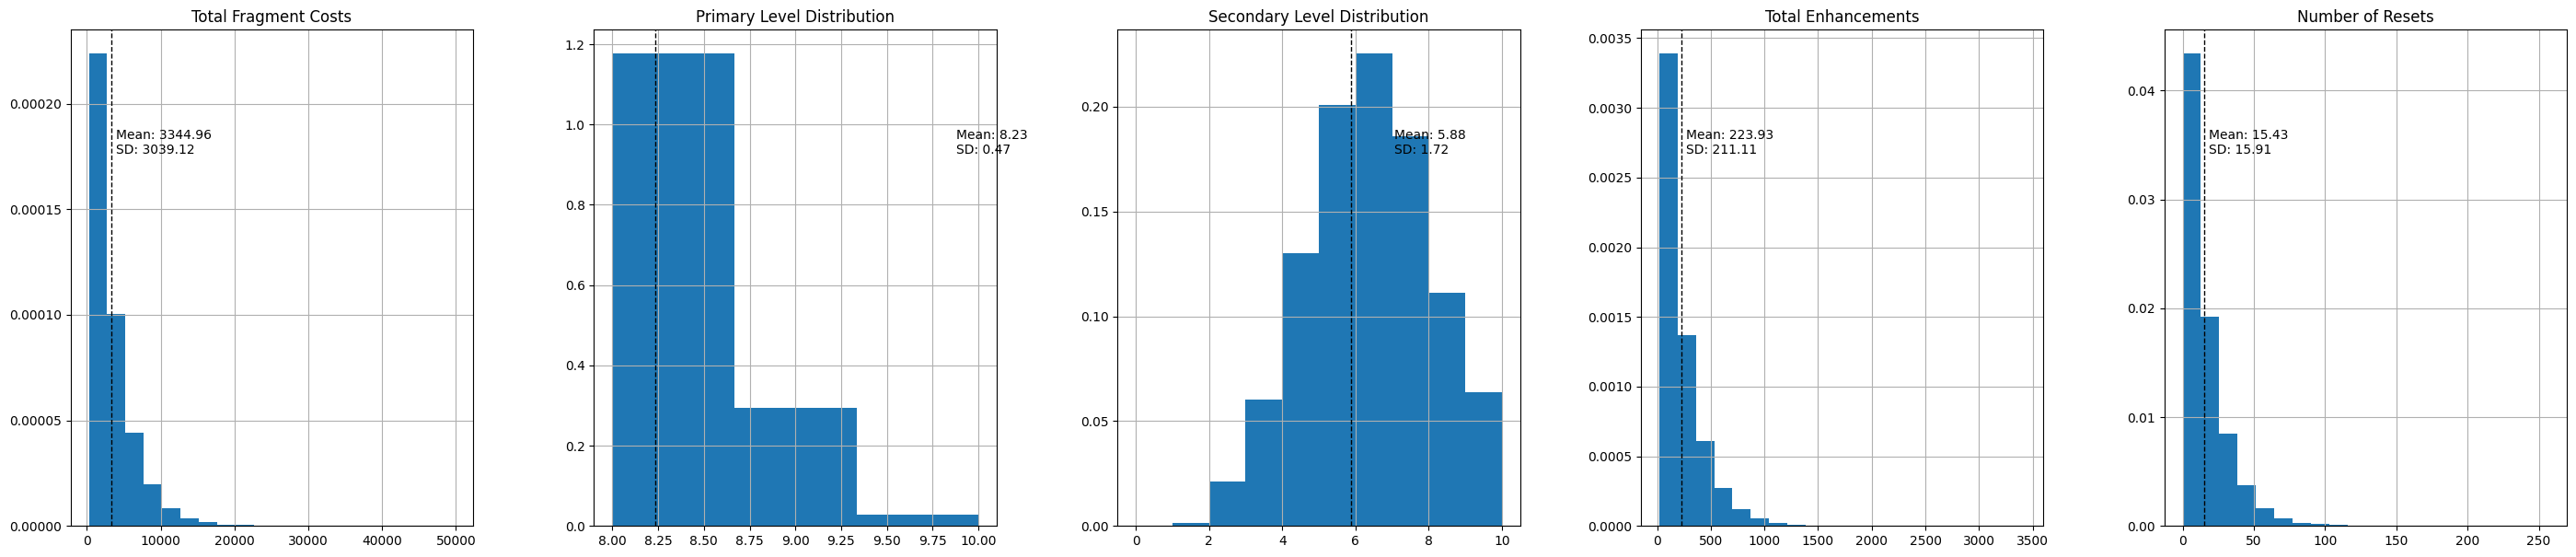

In [40]:
with open("./res_output_8target_halfpolicy.pkl", 'rb') as inFile:
    hexaRes = pickle.load(inFile)
hexDf = pd.DataFrame.from_dict(hexaRes)
del hexaRes

# plot hists and meanlines
binCnts = [20, 3, 10, 20, 20] # our primary will only be 8/9/10
fig, ax = plt.subplots(1, 5, figsize = (35, 7))
plotNames = ["Total Fragment Costs", "Primary Level Distribution", "Secondary Level Distribution", "Total Enhancements", "Number of Resets"]

for elemInd, relElem in enumerate(['totalFragCost', 'primaryLevel', 'secondaryLevel', 'totalEnhances', 'numResets']):
    hexDf.hist([relElem], bins = binCnts[elemInd], ax = ax[elemInd], density = True)
    ax[elemInd].set_title(plotNames[elemInd])
    plotMeanLine(hexDf[relElem], ax[elemInd])

    print("For relevant element {}:\n\tMax: {}\n\tMin: {}".format(relElem, hexDf[relElem].max(), hexDf[relElem].min()))

On average, we can say that our half-level policy, $\pi_\frac{l_d}{2}$ has saved us approximately $1100$ fragments on average at the expense of needing to do at least $15\pm15$ resets or use approximately 150m mesos. Seems like an adequate result for such a simple heuristic.

There is actually another interesting policy that was derived from some other KMS user that relied on heuristics instead. We can call this type of policy a tiered policy, as the general design of such a policy is simply a list of requirements for a certain given level for a given desired level. In other words, where the prior policy only contained two tiers (reset at lvl 10 and lvl 20), this new policy can have resets placed at any given level to try and optimize our results. The following was the given example for a desired level of 8:

Policy: (For $l_D=8$),

1. Enhance until next rule is reached and continue enhancing if rule passes.
2. If enhancement level is 10 and primary stat level is 3 or less, reset and try again.
3. If enhancement level is 14 and primary stat level is 4 or less, reset and try again.
4. If enhancement level is 17 and primary stat level is 5 or less, reset and try again.
5. If enhancement level is 19 and primary stat level is 6 or less, reset and try again.
6. If enhancement level is 20 and primary stat level is 7 or less, reset and try again.

In [41]:
# Codifies the above decision function for the given L_D = 8
desiredLvl = 8
policyPath = "./hexa_policies/tiered_policy_8.pkl"
policy = defaultdict(ddInitializer)

# Force reset with #2-#6
eLvlCheckpoints = [10, 14, 17, 19, 20]
reqLevels = [4, 5, 6, 7, 8]

for eInd, checkpointLvl in enumerate(eLvlCheckpoints):
    for lowPStatLevel in range(1, reqLevels[eInd]):
        policy[(checkpointLvl, lowPStatLevel)] = True

# Then convert our policy back to a normal dict so that unpickling doesn't throw a tantrum
# (Cannot find methods within a python noteboook, which can't function as a module...)
dPolicy = dict() 
for curPStatLevel in range(11):
    for curCoreLevel in range(curPStatLevel, 21):
        dPolicy[(curCoreLevel, curPStatLevel)] = policy[(curCoreLevel, curPStatLevel)]

# Save this policy for future use
with open(policyPath, 'wb') as outFile:
    pickle.dump(dPolicy, outFile)

And again we run our simulation and attempt to view the results from one million trials...

For relevant element totalFragCost:
	Max: 44040
	Min: 320
For relevant element primaryLevel:
	Max: 10
	Min: 8
For relevant element secondaryLevel:
	Max: 10
	Min: 0
For relevant element totalEnhances:
	Max: 3201
	Min: 20
For relevant element numResets:
	Max: 263
	Min: 0


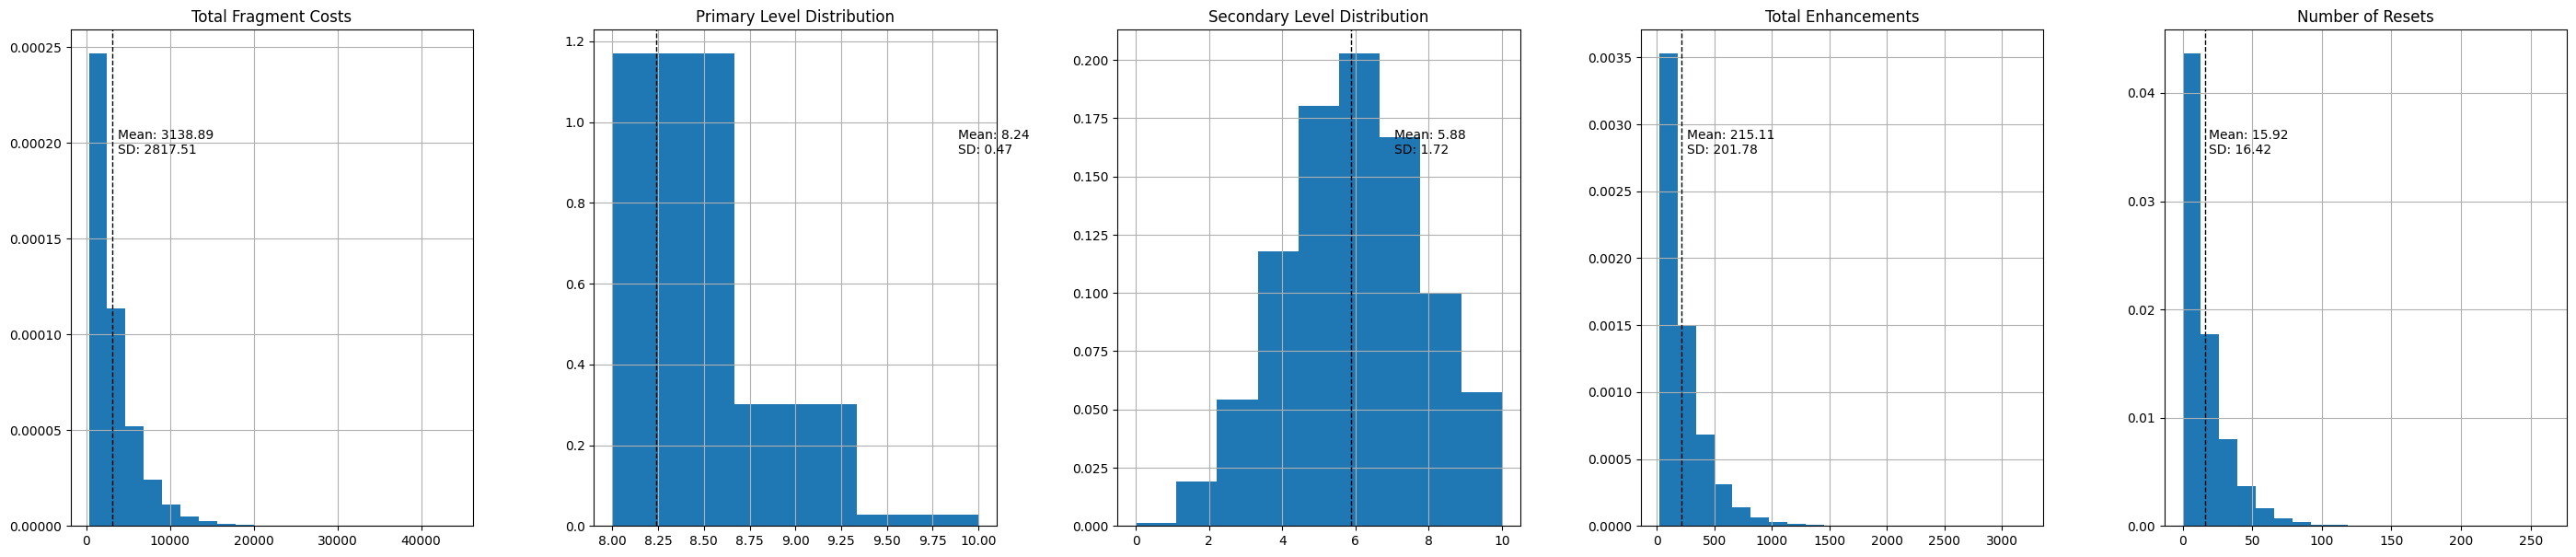

In [42]:
with open("./res_output_8target_tieredpolicy.pkl", 'rb') as inFile:
    hexaRes = pickle.load(inFile)
hexDf = pd.DataFrame.from_dict(hexaRes)
del hexaRes

# plot hists and meanlines
binCnts = [20, 3, 9, 20, 20] # our primary will only be 8/9/10
fig, ax = plt.subplots(1, 5, figsize = (35, 7))
plotNames = ["Total Fragment Costs", "Primary Level Distribution", "Secondary Level Distribution", "Total Enhancements", "Number of Resets"]

for elemInd, relElem in enumerate(['totalFragCost', 'primaryLevel', 'secondaryLevel', 'totalEnhances', 'numResets']):
    hexDf.hist([relElem], bins = binCnts[elemInd], ax = ax[elemInd], density = True)
    ax[elemInd].set_title(plotNames[elemInd])
    plotMeanLine(hexDf[relElem], ax[elemInd])

    print("For relevant element {}:\n\tMax: {}\n\tMin: {}".format(relElem, hexDf[relElem].max(), hexDf[relElem].min()))

This policy seems to save a little bit more, but, considering it's pretty much an extension of the above but with a few more checkpoints, it makes sense for the cost to not have decreased that significantly. Looking at the way the policy has been formulated, there's a very high likelihood that this is the most optimal policy (ignoring a few rounding errors related to potential states). That can be checked by running an exhaustive search over formulas of this type of tiered policy, which we might be looking at next...

## Policy Searching

For the most part, we will be interested in the sort of "tiered" enhancement criteria that was observed in the above policies as they seem to make the most sense for this kind of simulation. After all, if we set a rule to reset at some level, $l_i$, if we cannot reach some desired primary level $d_i$, then it does not make sense consider future criteria where we consider some primary stat level $d \le d_i$ for some node level $l \gt l_i$ because it would have been reset by this point. Along with the KMS user's post, we will also be assuming that having as many level tiers starting from the half point for levels is desired. It may be possible that a rule that does not begin from the half-point will be optimal, but testing all possible policies is far too time-consuming for a short analysis.

Here, we create some helper functions that will be used to enumerate all possible policies and also create policy dicts that correspond to the specific policy.

In [47]:
from collections import defaultdict

def createPolicy(nodeLevelReqs: list[int], primaryLevelReqs: list[int]) -> dict[tuple[int, int], bool]:
    """
    Creates a policy function that maps possible states (represented as a (nodeLevel, primLevel) tuple) to a
    boolean value representing whether or not to reset the current progress. By not resetting the progress,
    the policy function implicitly promotes enhancement (as the ultimate goal will always be the max level).

    This policy codifies policies consisting of the following format:
                If (d_cur < d_i) for (l_cur == l_i), reset the node. Otherwise, enhance.

    Args:
        nodeLevelReqs: Represents the l_i's in the above, or the node levels to associate with specific primary
                       stat levels
        primaryLevelReqs: Represents the d_i's in the above, or the primary levels for which to reset according
                          to the node levels with the equivalent indices.

    Returns:
        dict - A dictionary representing the mapping from states to the binary action outcome (reset / enhance)
    """
    # since we will be scanning within the notebook, a defaultdict should suffice and make calculations simpler
    policyDict : dict[tuple[int, int], bool] = defaultdict(lambda : False)

    # identify reset points according to the passed arguments
    for nodeLvlInd, checkpointLvl in enumerate(nodeLevelReqs):
        for lowPStatLevel in range(primaryLevelReqs[nodeLvlInd]):
            policyDict[(checkpointLvl, lowPStatLevel)] = True

    return policyDict

def enumerateStepPolicies(desNodeLevel: int, *, nodeMaxLevel: int = 20) -> set[tuple[int, ...]]:
    """
    Creates a set representing all possible tiered policies following the rules delineated above. To simplify things,
    since we will always have associated primary stat levels (D/2, D/2 + 1, D/2+2, ... D), we just return a tuple representing
    the associated node enhancement levels for the given node levels, (l_1, l_2, ..., l_{D/2}).

    Args:
        desNodeLevel: The desired final primary enhancement level to be reached for the hexa core

    Returns:
        set[tuple[int, ...]] - A set representing the node enhancement levels for the assumed set of primary stat levels.
    """
    def recursiveArrSelector(relArr: list, numToSelect: int, retSet: set, curTup: tuple):
        """
        Helper that selects one item of an array and selects other sequential items recursively.
        """
        # edge cases
        if numToSelect == 0: # finished selections
            retSet.add(curTup)
            return
        elif len(relArr) == 0: # no more possible selections with req length not met
            return
        
        # general case (select element and recurse)
        for aInd in range(len(relArr)):
            recursiveArrSelector(relArr[aInd+1:], numToSelect-1, retSet, curTup + (relArr[aInd],))

    # First find every possible associated node enhancement level
    totSet = set()
    recursiveArrSelector(list(range(nodeMaxLevel//2, nodeMaxLevel + 1)), (desNodeLevel//2)+1, totSet, ())

    # And return them
    return totSet
        

And we can also design the framework that will be used to first average across all elements and then pass that information to an outer function for processing.

In [48]:
# first we need a decorator that wil keep track of a specific element's average across trials
from typing import Callable

def runingAverageDecGen(itemKey: str):
    """
    Wraps a function that returns a list of dict values such that it returns that list of dicts
    but also returns, in a tuple, the average of a certain indexed value from within these dicts
    as defined by the passed itemKey.

    Args:
        itemKey: The item to take the running average of from within the list
    """
    avgSoFar = None
    numSampled = 0

    def averager(results: dict) -> float:
        """Takes in a set of results and calculates their average."""
        relItems = [elem[itemKey] for elem in results]
        return sum(relItems) / len(relItems)

    def averageCalcDec(testFunc: Callable):
        """Decorates a function by indexing a perticular key and finding its average value."""
        def averageCalc(*args, **kwargs):
            # Find test value
            testRes = testFunc(*args, **kwargs)

            # Update the average from the decorator
            nonlocal avgSoFar, numSampled
            if avgSoFar is None:
                avgSoFar = averager(testRes)
            else:
                avgSoFar += (averager(testRes) - avgSoFar) / (numSampled + 1)
            numSampled += 1

            return (avgSoFar, testRes)
        return averageCalc
    
    return averageCalcDec

Given the framework is designed to be executed by a user and not so much executed through functions, it will be a bit odd to adapt it properly. The flow of the sim allows force injection of a policy, but it is only allowed separate from the simulation itself, meaning it should be updated by using a callback that manipulates the framework's internal policy.

Passing the policy directly to the simulator itself would have probably made this a lot simpler, but then it would also incorporate unnecessary type-guessing work when implementing a terminal specific version of it...

In [49]:
# imports our framework now
import sys
if ".." not in sys.path: 
    sys.path.insert(0,"..")

from simulator import MarkovSim
from utils.env.hexastats import HexaStatFramework
from functools import partial
from tqdm.notebook import tqdm

In [52]:
# first create our fw to use along with the sim
curSim = MarkovSim()
testFw = HexaStatFramework()
curSim.selectFramework(testFw)

# Create some constants for the testing
DES_PRIM_LEVEL = 8
NUM_TRIALS_PER_BATCH = 10000
TOTAL_ITERS = 200000
NUM_BATCHES = TOTAL_ITERS // NUM_TRIALS_PER_BATCH

# defines the tolerance for the trial (can only be worse than current minimum by this much)
MEAN_TOL = 100

# wrap the trial with static params and decorate with average dec
staticParams = {'Target Primary Level': DES_PRIM_LEVEL, 'Custom Policy Name': "", 'Erda Frag Limit': 0}
genTestExecFunc = lambda : runingAverageDecGen("totalFragCost")(partial(curSim.simulate, NUM_TRIALS_PER_BATCH, staticParams, silent = True))

# updater func
updatePolicy = lambda newPolicy: testFw.forceInjectPolicy(newPolicy)

# since we're already at it, we can also initiate our resultant dict with the relevant initial entry to beat
resDict = {(10, 14, 17, 19, 20): (3138.89, 2000000)}
bestPolicy = (10, 14, 17, 19, 20)
minSoFar = 3138.89

And with that we can create the procedure similar to how we perform all other optimizations. We look at the optimal previous value and update based on that value. We can also early terminate on the off chance that the desired value is too far and unlikely to be competitive compared to another value based on some tolerance value.

In [53]:
# first iterate on possible policies
for curPartialPolicy in (pbar := tqdm(enumerateStepPolicies(DES_PRIM_LEVEL))):
    if curPartialPolicy in resDict:
        continue    # already tested value

    # otherwise continue with testing
    fullPolicy = createPolicy(curPartialPolicy, range(DES_PRIM_LEVEL//2, DES_PRIM_LEVEL+1))
    testExecFunc = genTestExecFunc() # ensures running average is recalculated per iter
    updatePolicy(fullPolicy)
    pbar.set_description("Processing level tuple: {}".format(curPartialPolicy))

    for curBatchIter in (batchPbar := tqdm(range(NUM_BATCHES), position = 1, leave = False)):
        # run test
        batchPbar.set_description("Processing Trials: {}/{}".format((curBatchIter + 1) * NUM_TRIALS_PER_BATCH, TOTAL_ITERS))
        avgSoFar, testOut = testExecFunc()
        batchPbar.set_postfix_str("T_Avg: {:.2f}".format(avgSoFar))

        # compare current average with optimal for early termination if worse than best
        if (avgSoFar - minSoFar) > MEAN_TOL:
            batchPbar.container.close()
            break

    # record final result
    resDict[curPartialPolicy] = (avgSoFar, (curBatchIter + 1) * NUM_TRIALS_PER_BATCH)

    # Here we adjust the optimum if it has changed
    if resDict[curPartialPolicy][0] < minSoFar:
        minSoFar = resDict[curPartialPolicy][0]
        bestPolicy = curPartialPolicy

  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [61]:
with open('hexa_policy_results.pkl', 'wb') as outFile:
    import pickle
    pickle.dump(resDict, outFile)

This was run on a remote server instead as I did have some credits lying around for this to be run. So, we can go ahead and load the results of the average calculation dict to identify the most promising tiered policies conforming to the way the KMS poster defined them.

In [62]:
with open('hexa_policy_results.pkl', 'rb') as inFile:
    import pickle
    resDict = pickle.load(inFile)

# Our results should be (partical_arg_tup, (average_cost, num_trials)) tuples
for arg, resTup in resDict.items():
    print("Template: Key - {} \t\t\t Results - {}".format(arg, resTup))
    break

Template: Key - (10, 14, 17, 19, 20) 			 Results - (3138.89, 2000000)


In [63]:
# And now we can sort by the results to identify the best keys
resSorted = sorted(list(resDict.items()), key = lambda dTup: dTup[1][0])

# Let's go ahead and print a policy formatter for convenience
def printFormattedPolicy(partialArgs: list[int], desPrimLevel: int = 8) -> None:
    for primLevelLim, nodeLevelThresh in zip(partialArgs, list(range(desPrimLevel//2, desPrimLevel+1))):
        print("\tIf by core level {}, the primary stat level is less than {}, reset core.".format(primLevelLim, nodeLevelThresh))

# And we can go ahead and print the best policies
MAX_LIM = 7
for relArgs, resTup in resSorted[:MAX_LIM]:
    print("Policy:")
    printFormattedPolicy(relArgs)
    print("\n Average Cost (from {} trials): {}".format(resTup[1], resTup[0]), end = "\n\n")

Policy:
	If by core level 10, the primary stat level is less than 4, reset core.
	If by core level 14, the primary stat level is less than 5, reset core.
	If by core level 18, the primary stat level is less than 6, reset core.
	If by core level 19, the primary stat level is less than 7, reset core.
	If by core level 20, the primary stat level is less than 8, reset core.

 Average Cost (from 200000 trials): 3124.6189500000005

Policy:
	If by core level 10, the primary stat level is less than 4, reset core.
	If by core level 15, the primary stat level is less than 5, reset core.
	If by core level 17, the primary stat level is less than 6, reset core.
	If by core level 19, the primary stat level is less than 7, reset core.
	If by core level 20, the primary stat level is less than 8, reset core.

 Average Cost (from 200000 trials): 3129.7892

Policy:
	If by core level 10, the primary stat level is less than 4, reset core.
	If by core level 15, the primary stat level is less than 5, reset c

Remember that from the very start, we were considering the specific policy defined by the partial node enhancement level tuple, $(10, 14, 17, 19, 20)$. It's not surprising to see that the majority of the optimal values are essentially equivalent to the given policy with a few values swapped. The optimal policy tuple above was defined by the key $(10, 13, 17, 19, 20)$, but that essentially amounts to pointing out how resetting earlier could *potentially* lead to a small amount of savings as the total number of erda sol fragments used (even with the more restrictive probability of attaining such a desired level). However, in the end this amounts to producing a functionally equivalent policy (in fact, almost all of the above policies are essentially a couple steps away from being equivalent to the original policy considered).

Could it be possible that another policy would lead to better savings by instead relying on a smaller and more restrictive subset of levels (perhaps starting with half the desired level + 1)? Well, we can test that too, but considering the likelihood of going to half seems to be a hurdle in and of itself, restricting ourselves to an even higher initial probability hurdle seems like the incorrect way of approaching it. I may look into all possibilities of triple tier policies, but that will be saved for some other time.